<a href="https://colab.research.google.com/github/dieko95/AlgoTrading/blob/develop/AlgoTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AlgoTrading

## Load Libraries and Data

https://pypi.org/project/GetOldTweets3/



```
python Exporter.py --query @RedHat --since 2014-01-01 --until 2019-01-15 --maxtweets 5000000
```



### Install Libraries

In [0]:
!pip install langdetect
!pip install vaderSentiment
!pip install -U -q PyDrive
!pip install -q xlrd

 

     |████████████████████████████████| 1.0MB 3.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
Successfully built langdetect
     |████████████████████████████████| 133kB 3.4MB/s 
     |████████████████████████████████| 993kB 3.5MB/s 


In [0]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np 
from langdetect import detect
import time
import seaborn as sns

### Load RHT Data

#### Google Validation to read Google Drive Files 

In [0]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


#### Load Twitter Past WebScraped Data

In [0]:

# link = 'https://drive.google.com/open?id=1NSuc3X37Z2r29mxKt92JFs0krF63aNNM'
# fluff, id = link.split('=')

# print(id)


In [0]:
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('Filename.csv')  
# tweetsDf = pd.read_csv('Filename.csv')

In [0]:
# tweetsDf.shape

#### Load Fundamental Past Data

In [0]:
import pandas as pd


file_id = '1P-479AOJBUh1gAcTuxhGtsZHr_17nYV5'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('exported.xlsx')

fundData = pd.read_excel('exported.xlsx')



#### Load Cleaned and Aggregated Tweets

In [0]:
file_id = '1wtJlq-ebnj-5cimnB6Yl_T2FNYy21Ul4'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('aggDfDay_v0.1.csv')

aggTweetsDay = pd.read_csv('aggDfDay_v0.1.csv')

#### Load Final Df for ML

In [0]:
file_id = '1XtSm0enUNyogW-xjWctuZLHmEDHwJbqh'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('mlFullDf.csv')

mlDf = pd.read_csv('mlFullDf.csv')

#### Loading Prototype - snippet



In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
# tweetsDf = pd.read_csv('redhatprototype.csv')

## Text Cleaning for Freshly Webscraped tweets 

Don't use this if you downloaded the csv cleaned tweets 

### First Cleaning Iteration

In [0]:
# Erasing Short Tweets

start_time = time.time()

tweetsDf.text = tweetsDf.text.apply(lambda x: len(str(x).split()) < 3 and np.nan or x) #If the tweet is less than 7 characters create a NA place Holder 


# Erasing Misc Characters 

tweetsDf.text = tweetsDf.text.replace(r'@\w*', '', regex = True) # Erases all usernames (word preceding @)
tweetsDf.text = tweetsDf.text.replace(r'#\w*', '', regex = True) # Erases hashtags
tweetsDf.text = tweetsDf.text.replace(r'https://.+', '', regex = True) # Erases URLS

print("Middle of program--- %s seconds ---" % (time.time() - start_time))

tweetsDf.text = tweetsDf.text.replace(r'http://.+', '', regex = True) # Erases URLS
tweetsDf.text = tweetsDf.text.replace(r'=>', '', regex = True) # Erases =>
tweetsDf.text = tweetsDf.text.replace(r'[$-/:-?{-~"^_`\[\]]', '', regex = True) #Replace weird characters
tweetsDf.text = tweetsDf.text.apply(lambda x: len(str(x).split()) < 3 and np.nan or x) #If the tweet is less than 3 characters create a NA place Holder 



tweetsDf = tweetsDf.dropna(subset=['text'])


# Erasing Non English Tweets 

print("Before detect --- %s seconds ---" % (time.time() - start_time))


tweetsDf.text = tweetsDf.text.apply(lambda x: detect(str(x)) != 'en' and np.nan or x) # Creates NA place holder for text that is not in english 

tweetsDf = tweetsDf.dropna(subset=['text'])



print("--- %s seconds ---" % (time.time() - start_time))


In [0]:
# Tweets that were deleted - 110 for RHT 
print(tweetsDf.describe(), '\n','\n'
     'Tweets Without Info: ', tweetsDf.shape[0] - tweetsDf.text.dropna().shape[0])

tweetsDf = tweetsDf.dropna(subset=['text'])
tweetsDf.shape

### Creation of sentiments

![alt text](https://cdn-images-1.medium.com/max/800/1*G8yV2iaqqfaGfmRPRem2Fw.png)

In [0]:
start_time = time.time()

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


analyzer = SentimentIntensityAnalyzer()

tweet = []
number_favourites = []
retweets = []
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []
timeStamp = []


for i in range(tweetsDf.shape[0]):
    tweet.append(tweetsDf.iloc[i,4])
    number_favourites.append(tweetsDf.iloc[i,3])
    retweets.append(tweetsDf.iloc[i,2])
    timeStamp.append(tweetsDf.iloc[i,1])
    vs_compound.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['compound'])
    vs_pos.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['pos'])
    vs_neu.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['neu'])
    vs_neg.append(analyzer.polarity_scores(tweetsDf.iloc[i,4])['neg'])
    
    
print("--- %s seconds ---" % (time.time() - start_time))

#### Aggregation by count of sentiments  

In [0]:

twitterDf = DataFrame({'Tweet': tweet,
                        'Favourites': number_favourites,
                        'retweets' : retweets,
                        'timeStamp' : timeStamp,
                        'Compound': vs_compound,
                        'Positive': vs_pos,
                        'Neutral': vs_neu,
                        'Negative': vs_neg})
twitterDf = twitterDf[['timeStamp','Tweet', 'Favourites', 'retweets','Compound',
                         'Positive', 'Neutral', 'Negative']]

twitterDf.shape

### Download Cleaned Tweets

In [0]:
# from google.colab import files

# twitterDf.to_csv('cleanedTwitter_v0.1.csv')
# files.download('cleanedTwitter_v0.1.csv')

## Aggregating By Day - Tweets

In [0]:
aggDf = twitterDf.drop(columns = 'Tweet')
aggDf.timeStamp = pd.to_datetime(aggDf.timeStamp) 
aggDf.set_index(aggDf["timeStamp"],inplace=True)
aggDfDay = aggDf.resample('D').sum()

# aggDfDay.Compound.value_counts()

aggDfDay

### Download Data

In [0]:
# from google.colab import files

# aggDfDay.to_csv('aggDfDay_v0.1.csv')
# files.download('aggDfDay_v0.1.csv')

### Index for tweets loaded from Local System

In [0]:
# 
print(aggTweetsDay.shape,aggFundDfDay.shape)

aggTweetsDay = aggTweetsDay.iloc[1:1826,:]

print(aggTweetsDay.shape,aggFundDfDay.shape)

In [0]:
aggTweetsDay.timeStamp = pd.to_datetime(aggTweetsDay.timeStamp) 
aggTweetsDay.set_index(aggTweetsDay["timeStamp"],inplace=True)

## Loading Price and Fundamentals 


In [0]:

fundData.head()

### Aggregate by Day

In [0]:
print('Before Agg',aggFundDf.shape)
aggFundDf = fundData
aggFundDf.timeStamp = pd.to_datetime(aggFundDf.timeStamp) 
aggFundDf.set_index(aggFundDf["timeStamp"],inplace=True)
aggFundDfDay = aggFundDf.resample('D').sum()
print('After Agg',aggFundDf.shape)

## Inner Join tables

In [0]:
finalDf = aggFundDfDay.join(aggTweetsDay,'timeStamp')
finalDf.head()


finalDfNames = [
       'Diluted EPS from Continuing Operations', 'EBIT Margin',
       'EBITDA Margin', 'Revenue % Growth', 'EBITDA % Growth', 'EBIT % Growth',
       'Net Income from Continuing Operations Sequential % Growth',
       'Net Debt to Equity', 'Favourites', 'retweets', 'Compound',
       'Positive', 'Neutral', 'Negative','Return'
]


finalDf = finalDf[finalDfNames]

from google.colab import files

finalDf.to_csv('mlFullDf.csv')
files.download('mlFullDf.csv')

# Machine Learning 

## Data Prep



### Creating Features and Target

In [0]:
mlDf = mlDf.dropna()

feature_names = [
       'Diluted EPS from Continuing Operations', 'EBIT Margin',
       'EBITDA Margin', 'Revenue % Growth', 'EBITDA % Growth', 'EBIT % Growth',
       'Net Income from Continuing Operations Sequential % Growth',
       'Net Debt to Equity', 'Favourites', 'retweets', 'Compound','timeStamp',
       'Positive', 'Neutral', 'Negative'
]

# Setting the Time Stamp as the Index
mlDf.timeStamp = pd.to_datetime(mlDf.timeStamp) 
mlDf.set_index(mlDf["timeStamp"],inplace=True)


# Create features and targets
# mlDf Loaded in First Section
features = mlDf[feature_names]
features = features.drop(columns="timeStamp")
targets = mlDf['Return']

# Create DataFrame from target column and feature columns
feature_and_target_cols = ['Return'] + feature_names
feat_targ_df = mlDf[feature_and_target_cols]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                                                      Return  ...  Negative
Return                                              1.000000  ...  0.005220
Diluted EPS from Continuing Operations              0.043457  ...  0.179761
EBIT Margin                                         0.030326  ...  0.059455
EBITDA Margin                                       0.029090  ...  0.046035
Revenue % Growth                                    0.033500  ...  0.094093
EBITDA % Growth                                     0.031476  ...  0.205550
EBIT % Growth                                       0.029349  ...  0.205432
Net Income from Continuing Operations Sequentia...  0.009910  ...  0.068854
Net Debt to Equity                                 -0.033897  ... -0.106857
Favourites                                          0.002452  ...  0.794346
retweets                                            0.001478  ...  0.696416
Compound                                            0.001805  ...  0.839535
Positive    

### Train Test Split

In [0]:
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
train_targets = targets[:train_size]
test_features = features[train_size:]
test_targets = targets[train_size:]
print(features.shape, train_features.shape, test_features.shape)

# train_features = train_features.drop(columns='timeStamp')
# test_features = test_features.drop(columns='timeStamp')

# train_features = train_features.dropna()
# test_features = test_features.dropna()

(1824, 14) (1550, 14) (274, 14)


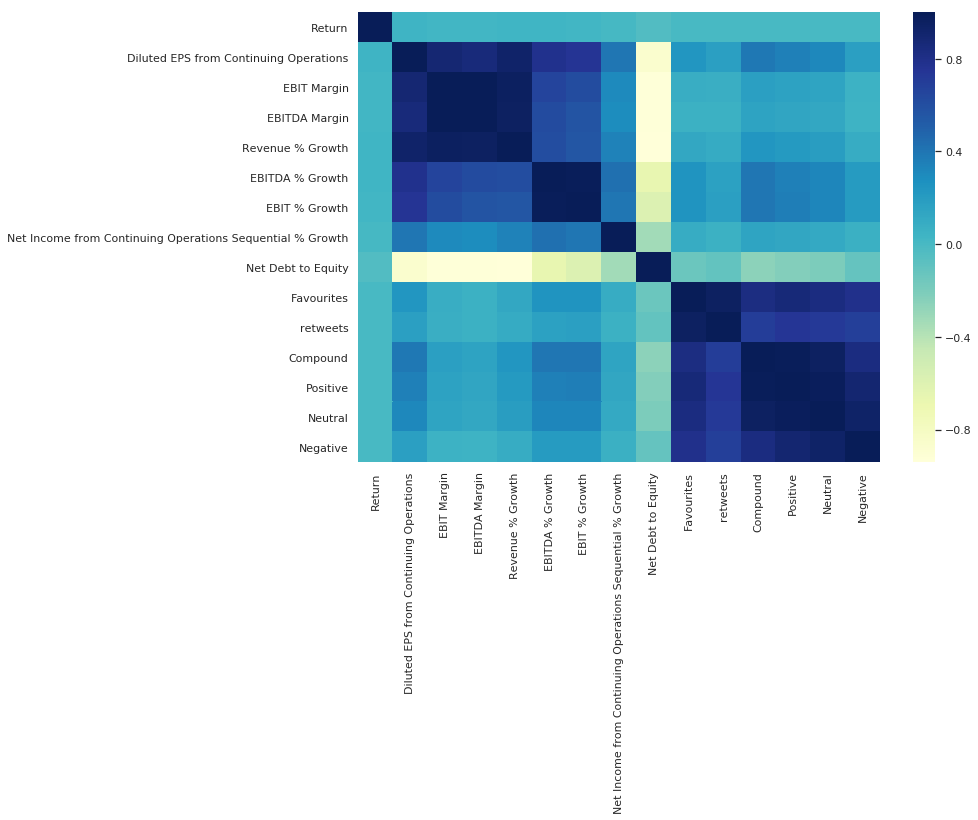

In [0]:
import seaborn as sns 

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(feat_targ_df.corr(), cmap="YlGnBu")

### First Generic Model - Decision Tree 

Hugely Overfitting! 

In [0]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor(random_state=0)

decFit = decision_tree.fit(train_features,train_targets)

print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features,test_targets))

0.9999786765405798
-0.7474783390027289


### Decision Tree with Cross Validation 

We can observe the R Squared scores in each train and test split, in all of the cases the data is overvitted

In [0]:
from sklearn.model_selection import cross_validate, cross_val_score



decision_tree = DecisionTreeRegressor(random_state=0)



scores = cross_validate(decision_tree,features,targets,return_train_score=True, cv=5)
scores  

{'fit_time': array([0.02122283, 0.01416802, 0.01592803, 0.01437211, 0.02219629]),
 'score_time': array([0.00204921, 0.00177455, 0.00186896, 0.00180459, 0.00189614]),
 'test_score': array([-2.27199045, -3.25758357, -0.54325437, -1.72530914, -0.21013178]),
 'train_score': array([0.999972  , 0.99997764, 0.99995611, 0.99998701, 0.99997562])}

In [0]:
#Visualizing the decision Tree

# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(decFit, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)

# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

### Decision Tree with GridSearch

In [0]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)
num_leafs = [5, 10, 20, 50, 100]

param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

decision_tree = DecisionTreeRegressor(random_state=0)

gs = GridSearchCV(estimator=decision_tree, param_grid=param_grid, scoring='r2', cv=5)

gs = gs.fit(features, targets)

gs.best_score_

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


-0.0059534952969904935

### Download Decision Tree Model 

In [0]:
# toExp = pd.DataFrame({'timeStamp':mlDf.index, 'predictedReturns':decFit.predict(features)})

In [0]:
# from google.colab import files

# toExp.to_csv('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')
# files.download('ReturnPredictions-SimpleRegTreeNoParam_v0.1.csv')

In [0]:
# tests = pd.DataFrame({'Original Returns':test_targets, 'predictedReturns':decFit.predict(test_features)})
# tests

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(random_state = 0)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features,test_targets))



0.7875499157518719
-0.2012072203642412


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from sklearn.model_selection import GridSearchCV

depths = np.arange(1, 21)
num_leafs = [5, 10, 20, 50, 100]

param_grid = [{'max_depth':depths,
              'max_leaf_nodes':num_leafs}]

gs = GridSearchCV(estimator=rfr, param_grid=param_grid,return_train_score=True, scoring='r2',verbose=0, cv=5)

gs = gs.fit(features, targets)




print('Best Score:{} \n Best Params: {}'.format(gs.best_score_, gs.best_params_))

Best Score:-0.005815546185934584 
 Best Params: {'max_depth': 1, 'max_leaf_nodes': 5}


#### Cross-Validation for Random Forest

In [0]:
from sklearn.model_selection import cross_validate, cross_val_score



decision_tree = DecisionTreeRegressor(random_state=0)



scores = cross_validate(rfr,features,targets,return_train_score=True, cv=5)
scores  

{'fit_time': array([0.02520251, 0.01544189, 0.01703024, 0.01490116, 0.01528621]),
 'score_time': array([0.00261521, 0.00361848, 0.00240612, 0.00232983, 0.0023303 ]),
 'test_score': array([-0.00347149, -0.00028206, -0.00568502, -0.01696987, -0.00266065]),
 'train_score': array([0.00791985, 0.00580272, 0.00667378, 0.00508564, 0.00933457])}

#### Fit Random Forest with gridsearched parameters 

In [0]:
rfr = RandomForestRegressor(max_depth=1, max_leaf_nodes=5 ,random_state = 0)
rfr.fit(train_features, train_targets)

# for feature in zip(feature_names, rfr.feature_importances_):
#     print(feature)

#### Feature Selection with Random Forest

Text(0.5, 0, 'Relative Importance')

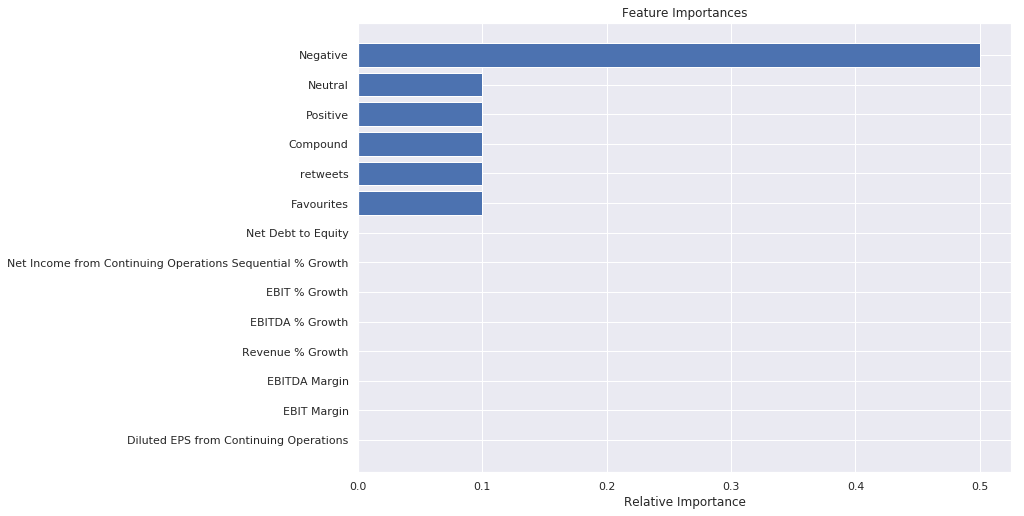

In [0]:
import matplotlib.pyplot as plt

importances = rfr.feature_importances_
indices = np.argsort(importances)

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')

### Gradient Boosting Regressor

In [0]:
import numpy as np
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

est = GradientBoostingRegressor(n_estimators=10000, learning_rate=0.1,
    max_depth=1, random_state=0, loss='ls').fit(train_features, train_targets)
# r2_score(test_targets, est.predict(test_features))    
# explained_variance_score(test_targets, est.predict(test_features))
explained_variance_score(train_targets, est.predict(train_features))

0.2452221282521364

#### Feature Selection for Gradient Boosting

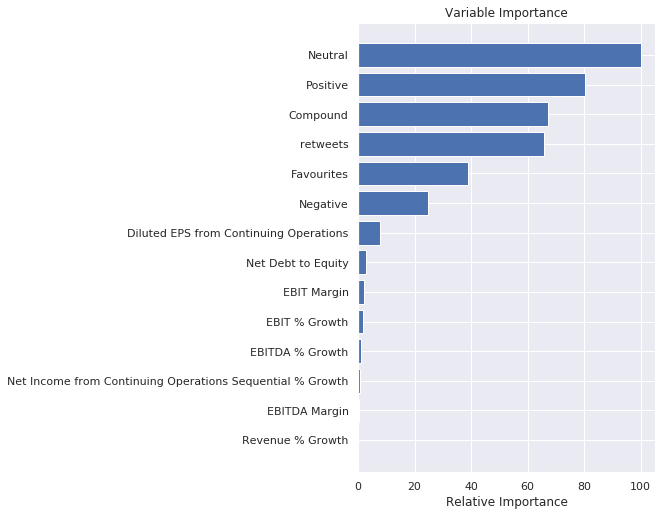

In [0]:
# Plot feature importance
feature_importance = est.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### Neural Nets

#### Scale Variables 

In [0]:
from sklearn.preprocessing import scale

# Remove unimportant features (weekdays)
train_features = train_features.iloc[:, :-4]
test_features = test_features.iloc[:, :-4]

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)


#### Neural net 1

In [0]:

from keras.models import Sequential
from keras.layers import Dense



from numpy.random import seed
seed(1)

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(40, activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=100)


Epoch 1/100
1550/1550 [==============================] - 0s 291us/step - loss: 0.0030
Epoch 2/100
1550/1550 [==============================] - 0s 56us/step - loss: 3.4140e-04
Epoch 3/100
1550/1550 [==============================] - 0s 53us/step - loss: 2.7138e-04
Epoch 4/100
1550/1550 [==============================] - 0s 50us/step - loss: 2.5956e-04
Epoch 5/100
1550/1550 [==============================] - 0s 47us/step - loss: 2.9560e-04
Epoch 6/100
1550/1550 [==============================] - 0s 51us/step - loss: 2.3935e-04
Epoch 7/100
1550/1550 [==============================] - 0s 61us/step - loss: 2.6790e-04
Epoch 8/100
1550/1550 [==============================] - 0s 55us/step - loss: 2.1798e-04
Epoch 9/100
1550/1550 [==============================] - 0s 46us/step - loss: 2.9699e-04
Epoch 10/100
1550/1550 [==============================] - 0s 55us/step - loss: 3.2076e-04
Epoch 11/100
1550/1550 [==============================] - 0s 53us/step - loss: 2.4812e-04
Epoch 12/100
1550/1550

Training Score 0.09762889767758742
Test Score -0.010446870213559833


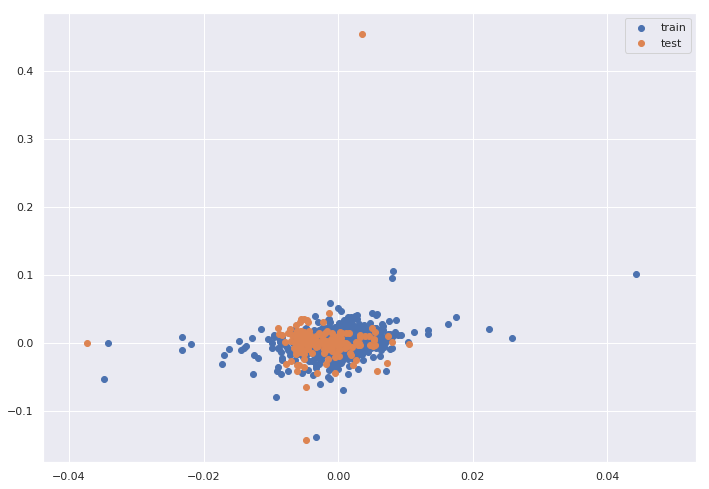

In [0]:
import seaborn as sns 
sns.set()

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print('Training Score {}'.format(r2_score(train_targets, train_preds)))
print('Test Score {}'.format(r2_score(test_targets, test_preds)))

# # Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

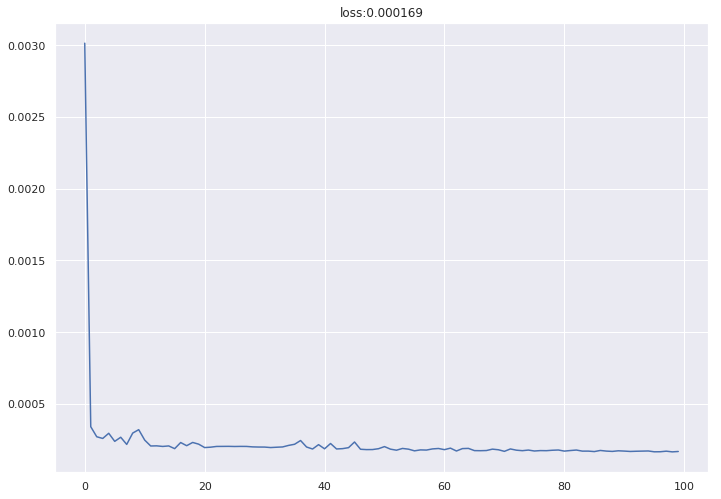

In [0]:
import seaborn as sns 
sns.set()

# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

### Neural Net 2 - Custom Loss Function 

In [0]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x7fa3d176c2f0>


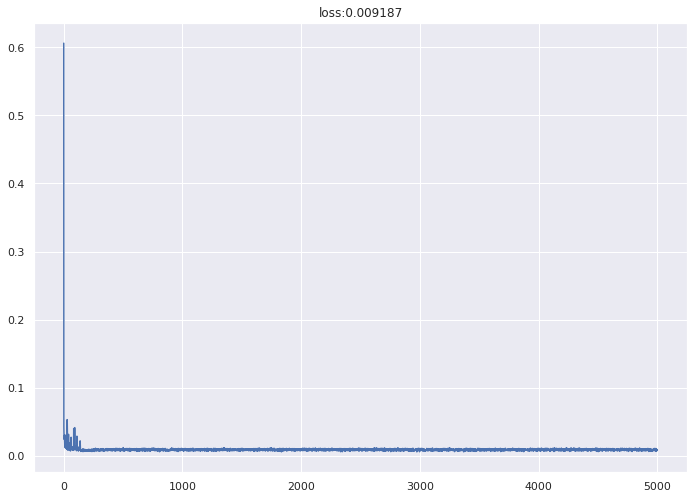

In [0]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=5000, verbose=False)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

-0.002144052129296359
-0.0010737119094283987


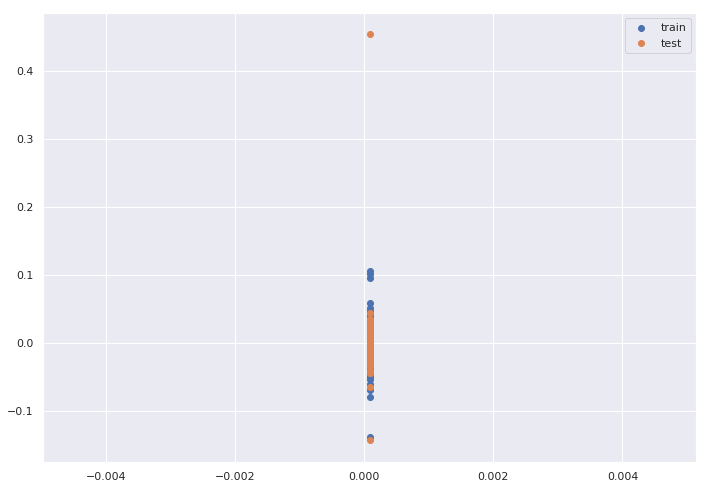

In [0]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()